In [1]:
from tensorflow.keras.applications import VGG16

In [2]:
# Instantiating the VGG16 CNN base
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

### Note:

You pass three arguments to the constructor:

- weights: specifies the weight checkpoint from which to initialize the model.
- include_top: refers to including (or not) the densely connected classifier on top of the network.
- input_shape: is the shape of the image tensors that you'll feed to the network. This argument is optional: if you don't pass it, the network will be able to process inputs of any size.

In [3]:
# Display model architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 2 options for using the pretrained CNN base:

- Run the base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But, this solution won't allow you to use data augmentation.
<br>
<br>
- Extend the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation because every input image goes through the convolutional base every time it's seen by the model. But, this technique is far more expensive than the first.

# Fast Feature Extraction without Data Augmentation

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = '/Users/theta/Desktop/DS-Courses/Deep Learning with Python/Chapter 5/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [11]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

print('train_features:', train_features.shape)
print('train_labels:', train_labels.shape)
print('validation_features:', validation_features.shape)
print('validation_labels:', validation_labels.shape)
print('test_features:', test_features.shape)
print('test_labels:', test_labels.shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
train_features: (2000, 4, 4, 512)
train_labels: (2000,)
validation_features: (1000, 4, 4, 512)
validation_labels: (1000,)
test_features: (1000, 4, 4, 512)
test_labels: (1000,)


### Note:

The extracted features are currently of shape (samples, 4, 4, 512). You'll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192)

In [12]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

In [16]:
# Defining and training the densely connected classifier
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.6555 - accuracy: 0.6305 - val_loss: 0.4460 - val_accuracy: 0.8360
Epoch 2/30
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.4433 - accuracy: 0.7950 - val_loss: 0.3767 - val_accuracy: 0.8420
Epoch 3/30
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.3643 - accuracy: 0.8445 - val_loss: 0.3367 - val_accuracy: 0.8570
Epoch 4/30
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.3247 - accuracy: 0.8700 - val_loss: 0.3005 - val_accuracy: 0.8930
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/sample - loss: 0.2973 - accuracy: 0.8790 - val_loss: 0.2863 - val_accuracy: 0.8950
Epoch 6/30
2000/2000 [==============================] - 7s 4ms/sample - loss: 0.2765 - accuracy: 0.8865 - val_loss: 0.2753 - val_accuracy: 0.8970
Epoch 7/30
2000/2000 [==============================] - 7s 3ms/sample - loss

In [17]:
import matplotlib.pyplot as plt

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

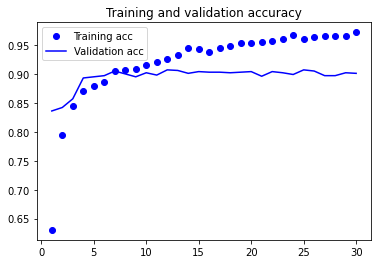

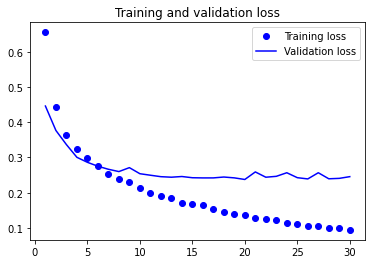

In [20]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Feature Extraction with Data Augmentation

### Note:

Because models behave just like layers, you can add a model (like conv_base) to a Sequential model just like you would add a layer.

In [21]:
from tensorflow.keras.layers import Flatten

In [22]:
# Build the model
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
# Display model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freezing the conv_base layer

Before you compile and train the model, it's very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the represntations previously learned.

In [24]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

# Freeze conv_base
conv_base.trainable = False

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


### Note:

Note that in order for these changes to take effect, you must first compile the model. If you ever modeify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

In [27]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
# Create generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=round(2000 / 20),
        epochs = 30,
        validation_data=validation_generator,
        validation_steps=round(1000 / 20))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 1117s 11s/step - loss: 0.5857 - accuracy: 0.6975 - val_loss: 0.4524 - val_accuracy: 0.8130
Epoch 2/30
100/100 [==============================] - 1140s 11s/step - loss: 0.4883 - accuracy: 0.7820 - val_loss: 0.3703 - val_accuracy: 0.8510
Epoch 3/30
100/100 [==============================] - 1529s 15s/step - loss: 0.4204 - accuracy: 0.8115 - val_loss: 0.3285 - val_accuracy: 0.8630
Epoch 4/30
100/100 [==============================] - 1131s 11s/step - loss: 0.4082 - accuracy: 0.8185 - val_loss: 0.3076 - val_accuracy: 0.8700
Epoch 5/30
100/100 [==============================] - 1153s 12s/step - loss: 0.3740 - accuracy: 0.8365 - val_loss: 0.2938 - val_accuracy: 0.8810
Epoch 6/30
100/100 [==============================] - 1138s 11s/step - loss: 0.3641 - accuracy: 0.8335 - val_loss: 0.2888 - val_accuracy: 0.8840
Epoch 7/30
100/100 [=================

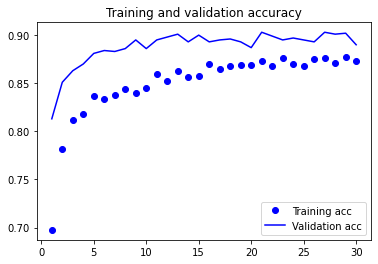

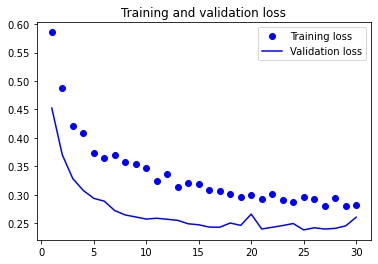

In [33]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine-Tuning a Pretrained Model

Another widely used technique for model reuse, compelentary to feature extraction, is fine-tuning. Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relavant for the problem at hand.

As stated earlier, it's necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained. If the classifier isn't already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.

### The steps for fine-tuning a network are as follow:

- Add your custom network on top of an already-trained base network.
- Freeze the base network.
- Train the part you added (in this case, the fully connected classifier)
- Unfreeze some layers in the base network.
- Jointly train both these unfrozen layers and the part you added (the fully connected classifier)

In [34]:
# Display the conv_base architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [35]:
# Freezing all layers up to a specific layer
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

### Note:

Now you can begin fine-tuning the network. You'll do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you're fine-tuning. Updates that are too large may harm these representations.

In [36]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=round(2000 / 20),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=round(1000 / 20))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 2358s 24s/step - loss: 0.2932 - accuracy: 0.8775 - val_loss: 0.2323 - val_accuracy: 0.9110
Epoch 2/100
100/100 [==============================] - 1831s 18s/step - loss: 0.2476 - accuracy: 0.8945 - val_loss: 0.2024 - val_accuracy: 0.9200
Epoch 3/100
100/100 [==============================] - 1535s 15s/step - loss: 0.2489 - accuracy: 0.8935 - val_loss: 0.1870 - val_accuracy: 0.9270
Epoch 4/100
100/100 [==============================] - 1330s 13s/step - loss: 0.2126 - accuracy: 0.9135 - val_loss: 0.1924 - val_accuracy: 0.9200
Epoch 5/100
100/100 [==============================] - 1493s 15s/step - loss: 0.2124 - accuracy: 0.9160 - val_loss: 0.2429 - val_accuracy: 0.9080
Epoch 6/100
100/100 [==============================] - 1479s 15s/step - loss: 0.1873 - accuracy: 0.9180 - val_loss: 0.2151 - val_accuracy: 0.9170
Epoch 7/100
100/100 [==========

100/100 [==============================] - 1354s 14s/step - loss: 0.0512 - accuracy: 0.9840 - val_loss: 0.1945 - val_accuracy: 0.9390
Epoch 56/100
100/100 [==============================] - 1363s 14s/step - loss: 0.0403 - accuracy: 0.9885 - val_loss: 0.2507 - val_accuracy: 0.9320
Epoch 57/100
100/100 [==============================] - 1358s 14s/step - loss: 0.0438 - accuracy: 0.9845 - val_loss: 0.2862 - val_accuracy: 0.9320
Epoch 58/100
100/100 [==============================] - 1362s 14s/step - loss: 0.0296 - accuracy: 0.9885 - val_loss: 0.2345 - val_accuracy: 0.9330
Epoch 59/100
100/100 [==============================] - 1359s 14s/step - loss: 0.0275 - accuracy: 0.9900 - val_loss: 0.3215 - val_accuracy: 0.9240
Epoch 60/100
100/100 [==============================] - 1358s 14s/step - loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.3135 - val_accuracy: 0.9280
Epoch 61/100
100/100 [==============================] - 1361s 14s/step - loss: 0.0360 - accuracy: 0.9870 - val_loss: 0.2587 - val_a

In [37]:
# Saving the model
# Used convolutional base of vgg16 pre-trained model, with
# block 5 unfrozen and retrained with classifier from previous model
model.save('vgg16_base_block5_unfrozen_with_classifier.h5')

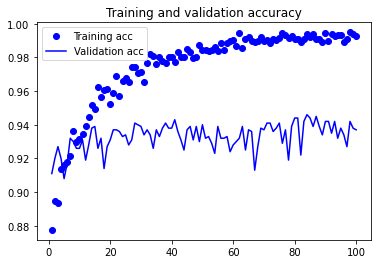

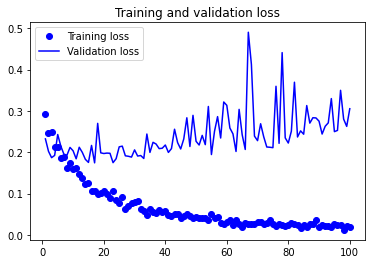

In [38]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

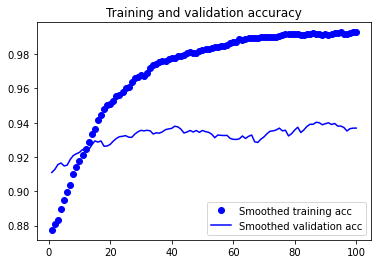

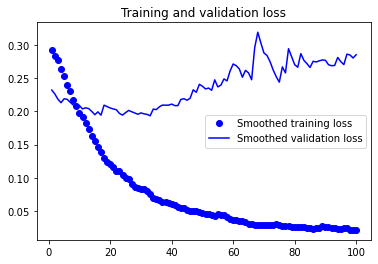

In [39]:
# Smoothing the plots with exponential moving averages
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()